In [1]:
# Notebook to plot input kinetics uncertainty along with new calculations

In [1]:
import os
import sys
import copy
import pickle

import numpy as np
import rmgpy.chemkin

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the base model and the covariance matrix
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
model_dir = '/scratch/harris.se/autoscience/uncorrelated/models'  # where the output cti's go

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

covariance_file = '/work/westgroup/harris.se/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)


In [13]:
def plot_reaction_uncertainty(reaction, uncertainty, title=None):
    # function to show how the reaction kinetics have been changed
    
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    T = np.linspace(300, 3000, 1001)

    k_orig = np.zeros(len(T))
    for i in range(0, len(T)):
        k_orig[i] = reaction.get_rate_coefficient(T[i], 101325)
    plt.plot(1000.0 / T, np.log(k_orig))
    
    upper_bound = np.log(k_orig) + uncertainty
    lower_bound = np.log(k_orig) - uncertainty
    plt.fill_between(1000.0 / T, lower_bound, y2=upper_bound, step="pre", alpha=0.4, color='tab:blue')
    
    if title:
        plt.title(title)
    plt.legend(['Estimate', 'Uncertainty'])
    plt.show()

In [5]:
def compare_original_calculated(original_reaction, new_reaction, original_uncertainty, new_uncertainty):  # Plot it all together
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    T = np.linspace(300, 3000, 1001)

    k_orig = np.zeros(len(T))
    k_new = np.zeros(len(T))
    for i in range(0, len(T)):
        k_orig[i] = original_reaction.get_rate_coefficient(T[i], 101325)
        k_new[i] = new_reaction.get_rate_coefficient(T[i], 101325)
    plt.plot(1000.0 / T, np.log(k_orig))
    plt.plot(1000.0 / T, np.log(k_new))

    
    upper_bound_orig = np.log(k_orig) + original_uncertainty
    lower_bound_orig = np.log(k_orig) - original_uncertainty
    plt.fill_between(1000.0 / T, lower_bound_orig, y2=upper_bound_orig, step="pre", alpha=0.4, color='tab:blue')
    
    upper_bound_new = np.log(k_new) + new_uncertainty
    lower_bound_new = np.log(k_new) - new_uncertainty
    plt.fill_between(1000.0 / T, lower_bound_new, y2=upper_bound_new, step="pre", alpha=0.4, color='tab:orange')
    


    plt.legend(['Original', 'Calculated', 'Original Uncertainty', 'Calculated Uncertainty'])
    plt.show()

In [8]:
# Load the new kinetics library
DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)

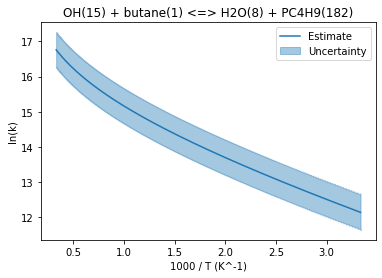

In [14]:
# Plot the original reaction and uncertainty
reaction_index = 288
plot_reaction_uncertainty(reaction_list[reaction_index], Sigma_k[reaction_index, reaction_index], title=str(reaction_list[reaction_index]))

butane(1) + OH(15) <=> H2O(8) + PC4H9(182)
Arrhenius(A=(72.7486,'cm^3/(mol*s)'), n=3.36371, Ea=(-5.80962,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.14581, dn = +|- 0.0178825, dEa = +|- 0.0973161 kJ/mol""")
1.14581


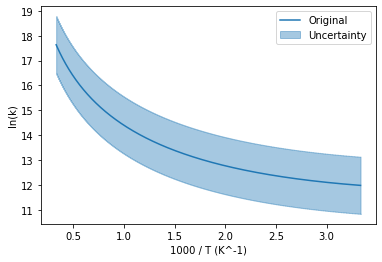

In [61]:
# plot the new reaction and its uncertainty
reaction_index = 288

# find the corresponding reaction in the library
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
    if index == reaction_index:
        print(entry)
        print(entry.data)
        comment = entry.data.comment
        new_uncertainty = float(comment.split('dA')[-1].split(',')[0].split()[-1])
        print(new_uncertainty)
        plot_reaction_uncertainty(entry.data, new_uncertainty)
        break

C4H8(188) + HCO(19) <=> CH2O(9) + C4H7(190)
Arrhenius(A=(7.99625e-06,'cm^3/(mol*s)'), n=5.38521, Ea=(32.5638,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 2.90691, dn = +|- 0.140194, dEa = +|- 0.762932 kJ/mol""")


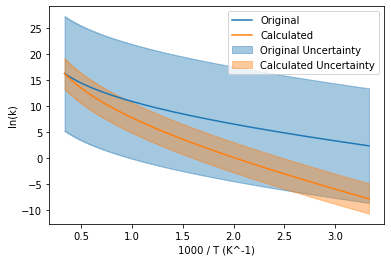

In [69]:
# plot the new vs. the old
# reaction_index = 247
# reaction_index = 288
# reaction_index = 591
# reaction_index = 748
reaction_index = 749

# find the corresponding reaction in the library
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
    if index == reaction_index:
        print(entry)
        print(entry.data)
        comment = entry.data.comment
        new_uncertainty = float(comment.split('dA')[-1].split(',')[0].split()[-1])
        break
compare_original_calculated(reaction_list[reaction_index], entry.data, Sigma_k[reaction_index, reaction_index], new_uncertainty)

In [63]:
# List reactions in the library
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
    print(index, entry)

247 butane(1) + OH(15) <=> H2O(8) + SC4H9(183)
288 butane(1) + OH(15) <=> H2O(8) + PC4H9(182)
591 CH3CHO(35) + C3H5-A(94) <=> C3H6(12) + CH3CO(20)
748 C4H8(189) + HCO(19) <=> CH2O(9) + C4H7(190)
749 C4H8(188) + HCO(19) <=> CH2O(9) + C4H7(190)
